# "News representation from pretrained Sentence-BERT"
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [bert, nlp]
- image: 
- hide: true
- search_exclude: true
- metadata_key1: transformer
- metadata_key2: nlp

Pre-requisites:  
- Transformer (`pip install transformers`)
- MulticoreTSNE (`pip install MulticoreTSNE`)
- Pytorch
- Altair (`!pip install altair`)
- Matplotlib



In [49]:
#!pip install transformers
#!pip install MulticoreTSNE

In [50]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import pyplot as plt
import altair as alt
from typing import List

from MulticoreTSNE import MulticoreTSNE as TSNE
from transformers import AutoTokenizer, AutoModel
from torch.nn import functional as F



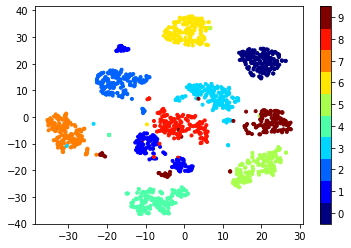

In [51]:
#hide
%matplotlib inline
from sklearn.datasets import load_digits
from MulticoreTSNE import MulticoreTSNE as TSNE
from matplotlib import pyplot as plt

digits = load_digits()
embeddings = TSNE(n_jobs=4).fit_transform(digits.data)
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]
plt.scatter(vis_x, vis_y, c=digits.target, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

## Text representation

In [52]:
tokenizer = AutoTokenizer.from_pretrained('deepset/sentence_bert')
model = AutoModel.from_pretrained('deepset/sentence_bert')

def get_representation(texts: List[str]):
    inputs = tokenizer.batch_encode_plus(texts,
                                     return_tensors='pt',
                                     pad_to_max_length=True)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    output = model(input_ids, attention_mask=attention_mask)[0]
    sentence_rep = output.mean(dim=1)
    return sentence_rep


## Visualize embedding

In [53]:
def plot_embedding(embedding, label=[], input_tensor=True, n_jobs=4):
    # Plot embedding and annotate with texts

    reduced_embed = reduce_embedding(embedding)
    vis_x = reduced_embed[:, 0]
    vis_y = reduced_embed[:, 1]
    plt.scatter(vis_x, vis_y,  marker='.')
    
    # annotate with labels
    if label != []:
        i = 0
        for x,y in zip(vis_x, vis_y):

            alabel = label[i]

            plt.annotate(alabel, # this is the text
                         (x,y), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center') # horizontal alignment can be left, right or center

            i += 1

    plt.show()
  
def reduce_embedding(embedding, n_jobs=4):
  # reduce embedding to 2 dimension using t-sne
  nar_embedding = embedding.detach().numpy()
  reduced_embedding = TSNE(n_jobs).fit_transform(nar_embedding)
  return reduced_embedding

def plot_interactive(x, y, color, title_text="news embedding"):
    # interactive plot
    df = pd.DataFrame({"x": x, "y": y, "color": color})
    chart = Chart(df).mark_point().encode(
        x="x", y="y", color="color", tooltip=["color:N"]).properties(
            title=f"t-SNE dimensions of {title_text}")
        
    chart.properties(width=600, height=300)
    chart.display()

In [54]:
# Example courtesy: https://github.com/UKPLab/sentence-transformers

# Corpus with example sentences
corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'A cheetah is running behind its prey.'
          ]

# Query sentences:
queries = ['A man is eating pasta.', 'Someone in a gorilla costume is playing a set of drums.', 'A cheetah chases prey on across a field.']


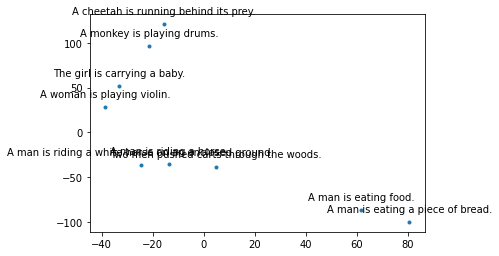

In [55]:
encodings = get_representation(corpus)    
plot_embedding(encodings, corpus)

In [56]:
# Finding similarity of corpus[0] with corpus[1:]

similarities = F.cosine_similarity(encodings[:1], encodings[1:])
closest = similarities.argsort(descending=True)
for ind in closest:
    print(f'label: {corpus[ind+1]} \t similarity: {similarities[ind]}')

label: A man is eating a piece of bread. 	 similarity: 0.6846262812614441
label: Two men pushed carts through the woods. 	 similarity: 0.2318623811006546
label: A man is riding a horse. 	 similarity: 0.21302978694438934
label: A man is riding a white horse on an enclosed ground. 	 similarity: 0.19911342859268188
label: A monkey is playing drums. 	 similarity: 0.0613873228430748
label: A cheetah is running behind its prey. 	 similarity: -0.07709453254938126
label: A woman is playing violin. 	 similarity: -0.11077529937028885
label: The girl is carrying a baby. 	 similarity: -0.1298864632844925


## News embedding

News courtesy: https://www.bbc.com/news

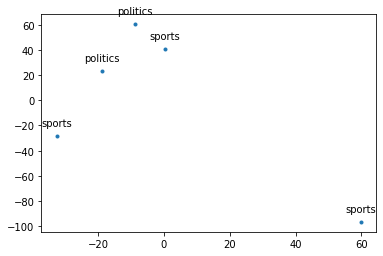

In [57]:
news = [{
    
    "sports" : """
    The NBA has confirmed there will be no games for a third straight day but the play-offs will resume on Saturday.

A host of US sports games were postponed after the Milwaukee Bucks chose not to play on Wednesday in protest at the shooting of Jacob Blake.

Blake, a black man, was shot seven times in the back by police on Sunday in Kenosha, Wisconsin, near Milwaukee.

The WNBA has said it will resume play on Friday having postponed all its games the previous two days.

Sportshour podcast: The week the sporting world took action
NBA commissioner Adam Silver and Michele Roberts, executive director of the players' association NBPA, released a joint statement on Friday, saying there had been "a candid, impassioned and productive conversation yesterday between NBA players, coaches and team governors regarding next steps to further our collective efforts and actions in support of social justice and racial equality".

It added "all parties agreed to resume" play-off games on Saturday provided "the league together with the players will work to enact the following commitments":

The NBA and its players have agreed to immediately establish a social justice coalition, with representatives from players, coaches and governors.
In every city where the league franchise owns and controls the arena property, team governors will continue to work with local elections officials to convert the facility into a voting location for the 2020 general election to allow for a safe in-person voting option for communities vulnerable to Covid.
The league will work with the players and network partners to create and include advertising spots in each NBA play-off game dedicated to promoting greater civic engagement in national and local elections and raising awareness around voter access and opportunity.
Game five of the Bucks' series with Orlando Magic has been rescheduled for 20:30 BST on Saturday, followed by Oklahoma City Thunder's game with Houston Rockets and Los Angeles Lakers' fixture with Portland Trail Blazers.

Sunday's games begin with Boston Celtics facing Toronto Raptors at 18:00 BST, before LA Clippers play Dallas Mavericks and Utah Jazz take on Denver Nuggets.
    """,
    },

    {
        "politics": """
        Activists in Montreal have pulled down a statue of Canada's first prime minister Sir John A MacDonald, who was linked to cruel policies that killed many indigenous people in the late 19th Century.

Video captured the moment the statue's head flew off and bounced on the pavement nearby.

Quebec's head of government condemned it as "unacceptable".

"Destroying parts of our history is not the solution," said François Legault.

No arrests have been made, according to Canadian broadcaster CBC.

MacDonald was prime minister of Canada for 19 years in the 1860s-1890s and is remembered for his nation-building policies but he also created the residential schools system.

For more than a century the system forcibly removed at least 150,000 indigenous children from their homes and sent them to state-funded boarding schools. Many children were abused and some died, and they were were forbidden from speaking their own language or practising their culture.

A government report in 2015 called the practice "cultural genocide".

He was accused of allowing famine and disease to kill many indigenous people and his government forced some First Nation communities to leave their traditional territories, withholding food until they did so.
        
        """
    },
    
    {
        "sports": """
        Alexander Kristoff timed his sprint finish to perfection to win the opening stage of the Tour de France in Nice.

After a large group crashed inside the final 3km, Norwegian Kristoff, 33, surged home in a sprint also involving Ireland's Sam Bennett, who was fourth.

Rain made the roads treacherous and led to several crashes, with Pavel Sivakov of Team Ineos twice coming off.

Ineos' defending champion Egan Bernal largely avoided the trouble and finished safely in the peloton.

Colombia's Nairo Quintana crashed, while Astana's decision to up the pace on the final descent from Levens saw Miguel Angel Lopez slide into a road sign and prompted some stern exchanges towards the team from other riders in the peloton.

Ineos' Luke Rowe called Astana's move "pretty stupid".

"I have to say 'chapeau' to the whole peloton - minus Astana to hit it down one climb and, as a result, their leader was left on his back," the British rider said.

France's Julian Alaphilippe was also caught in a crash, while compatriot Thibaut Pinot - one of the race favourites - fell heavily towards the end and rolled over the line with a ripped jersey.

However, because the crash happened inside the final 3km, he was credited with the same time as the group he was riding with, so ended up losing no time on his rivals for the overall win.

The riders face a 186km mountainous second stage on Sunday, with two climbs above 1,500m.
        """
    },

    {
        "politics": """Tens of thousands of people have rallied in the Belarusian capital Minsk for a new unsanctioned protest against President Alexander Lukashenko.
Riot police charged protesters near the presidential palace, firing pepper spray and wielding batons, and several dozen arrests were made.
Protesters are seeking the resignation of the long-time president.
They accuse the authorities of rigging his re-election just over a month ago, sparking deadly mass unrest.
At least four people have died and hundreds have been injured since then, as the government tried to stamp out dissent.
A number of opposition figures have fled the country, On Saturday, activist Olga Kovalkova became the latest to say she had taken refuge in neighbouring Poland amid threats of imprisonment.
What's happening in Belarus?
Belarus cracks down on journalists covering unrest
'We can breathe for the first time in our lives'
Mr Lukashenko, in power since 1994, has accused Western nations of interfering.
Protesters, human rights activists and observers say riot police are brutally suppressing peaceful marches.
The former Soviet republic borders Russia, on which it depends heavily for energy and with which it historically has close ties, as well as Ukraine and EU states."""
    },

    {"sports":"""Jos Buttler guided England to a six-wicket victory over Australia in the second Twenty20 international to clinch the three-match series.

                  Buttler batted throughout for his 77 from 54 balls as the hosts reached their target of 158 with seven balls left.

                  After the loss of Jonny Bairstow, who hit his own wicket in the third over, Buttler batted patiently in a stand of 87 with Dawid Malan.

                  Malan fell for 42, and Tom Banton and Eoin Morgan followed in a collapse of 3-29, but the assured Buttler held firm.

                  With 18 needed from the final two overs, Moeen Ali hit 10 from two balls before Buttler sealed the victory with a huge six.

                  A brilliant start with the ball by England had earlier seen Australia fall to 3-2 and 30-3, before the tourists scrapped to their total.

                  After snatching victory in Friday's series opener, England now lead 2-0 with only the final match on Tuesday to come.

                  Clips and reaction from England's win
                  Brilliant Buttler ensures no repeat
                  In the first game of the series Australia were cruising to victory before a late collapse saw England win.

                  Here, when Malan holed out on the slog sweep at the end of an impressive knock, Banton top-edged to deep square leg and Morgan hit to extra cover, a similar twist was possible.

                  However, Buttler provided what Australia lacked - a calm head to see the game home.

                  He was not his attacking usual self for much of the innings. Although the right-hander found boundaries effectively with trademark reverse sweeps, England only took 44 from the first six overs of their chase.

                  Instead, he batted maturely with Malan and found the boundary when needed. One back-foot drive through the covers after the loss of Banton relieved pressure.

                  Buttler's presence as a set batsman allowed Moeen to attack the penultimate over and he hit Adam Zampa for six over extra cover before adding a four in the same region from the next ball.

                  Australia captain Aaron Finch's gamble to bowl his leg-spinner Zampa proved decisive. Buttler emphatically launched him down the ground and into the stands to end the game.

            """
    }
]

news_embedding = get_representation([n[list(n.keys())[0]] for n in news])
plot_embedding(news_embedding, label = [list(n.keys())[0] for n in news])

## Embedding of the [Liar fake news benchmark dataset](https://sites.cs.ucsb.edu/~william/data/liar_dataset.zip)

In [58]:
%%bash
wget https://www.cs.ucsb.edu/~william/data/liar_dataset.zip
unzip liar_dataset.zip
ls

Archive:  liar_dataset.zip


--2020-09-06 21:20:12--  https://www.cs.ucsb.edu/~william/data/liar_dataset.zip
Resolving www.cs.ucsb.edu (www.cs.ucsb.edu)... 23.185.0.3, 2620:12a:8000::3, 2620:12a:8001::3
Connecting to www.cs.ucsb.edu (www.cs.ucsb.edu)|23.185.0.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sites.cs.ucsb.edu/~william/data/liar_dataset.zip [following]
--2020-09-06 21:20:12--  https://sites.cs.ucsb.edu/~william/data/liar_dataset.zip
Resolving sites.cs.ucsb.edu (sites.cs.ucsb.edu)... 128.111.27.13
Connecting to sites.cs.ucsb.edu (sites.cs.ucsb.edu)|128.111.27.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1013571 (990K) [application/zip]
Saving to: ‘liar_dataset.zip.1’

     0K .......... .......... .......... .......... ..........  5%  256K 4s
    50K .......... .......... .......... .......... .......... 10%  393K 3s
   100K .......... .......... .......... .......... .......... 15%  772K 2s
   150K .......... .......

In [59]:
!ls

liar_dataset.zip    README	 test.tsv   valid.tsv
liar_dataset.zip.1  sample_data  train.tsv


In [60]:
%%bash
head -n 5 train.tsv

2635.json	false	Says the Annies List political group supports third-trimester abortions on demand.	abortion	dwayne-bohac	State representative	Texas	republican	0	1	0	0	0	a mailer
10540.json	half-true	When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.	energy,history,job-accomplishments	scott-surovell	State delegate	Virginia	democrat	0	0	1	1	0	a floor speech.
324.json	mostly-true	Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."	foreign-policy	barack-obama	President	Illinois	democrat	70	71	160	163	9	Denver
1123.json	false	Health care reform legislation is likely to mandate free sex change surgeries.	health-care	blog-posting			none	7	19	3	5	44	a news release
9028.json	half-true	The economic turnaround started at the end of my term.	economy,jobs	charlie-crist		Florida	democrat	15	9	20	19	2	an interview on CNN


In [61]:
import pandas as pd
statements = pd.read_csv("valid.tsv", sep="\t", header=None)
statements = statements[1:50]  # taking a subset to reduce computation complexity
statements.head()
statements.shape

statements_body = statements[2].tolist()
statements_label = statements[1].tolist()
label_set = set(statements_label)

statements_embedding = get_representation(statements_body)
reduced_embed = reduce_embedding(statements_embedding)
vis_x = reduced_embed[:, 0]
vis_y = reduced_embed[:, 1]

plot_interactive(vis_x, vis_y, statements_label)

alt.Chart(...)

Reference:  

- [t-sne embed and tensorboard visualization](https://github.com/joeddav/blog/blob/master/_notebooks/2020-05-29-ZSL.ipynb)  
- [Text classification in Pytorch](https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b)  
- [Notebook on sentence-bert](https://github.com/joeddav/blog/blob/master/_notebooks/2020-05-29-ZSL.ipynb)
